# 1. Classification

In [1]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import *
from sklearn.metrics import *
%config IPCompleter.greedy=True

In [2]:
#plot tools
def plot_roc_curve(X_test, y_test, all_clfs, clf_names):
    roc_scores = dict()
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    np.random.seed(0)

    for clf, clf_name in zip(all_clfs, clf_names):
        probs = clf.predict_proba(X_test)
        if probs.shape[1] > 2:
            plot_multiclass_roc(y_test, probs, clf_name)
            continue
        preds = probs[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, preds)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        roc_scores[clf_name] = roc_auc
#         np.random.seed(abs(hash(clf_name))%(2**32))
        plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
        plt.legend(loc = 'lower right')
    plt.savefig(image_path+file.split('.')[0]+'_roc')
    plt.show()
    return roc_scores

def plot_pr_curve(X_test, y_test, all_clfs, clf_names):
    pr_scores = dict()
    plt.figure(figsize=(10,8))
    plt.title('Precision-Recall Curve')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    np.random.seed(0)
    
    for clf, clf_name in zip(all_clfs, clf_names):
        probs = clf.predict_proba(X_test)
        if probs.shape[1]>2:
            plot_multiclass_pr(y_test, probs, clf_name)
            continue
        preds = probs[:,1]
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, preds)
        pr_auc = sklearn.metrics.auc(recall, precision)
        pr_scores[clf_name] = pr_auc
#         np.random.seed(abs(hash(clf_name))%(2**32))
        plt.plot(recall, precision, 'b', label = '%s (AUC = %0.3f)' % (clf_name,pr_auc), c=np.random.rand(3,))
        plt.legend(loc = 'lower left')
    plt.savefig(image_path+file.split('.')[0]+'_pr')
    plt.show()
    return pr_scores

def plot_multiclass_roc(y_true, y_probas, clf_name):
    skplt.metrics.plot_roc(y_true, y_probas, title=clf_name+" ROC Curve", figsize=(10,8))
    skplt.metrics.plt.savefig(image_path+file.split('.')[0]+'-'+clf_name+'_multiclass_roc')
    skplt.metrics.plt.show()
    
def plot_multiclass_pr(y_true, y_probas, clf_name):
    skplt.metrics.plot_precision_recall(y_true, y_probas, title=clf_name+" PR Curve", figsize=(10,8))
    skplt.metrics.plt.savefig(image_path+file.split('.')[0]+'-'+clf_name+'_multiclass_pr')
    skplt.metrics.plt.show()

In [3]:
# classifiers
def train_KNN():
    print('Training KNN ...')
    knn = KNeighborsClassifier()
#     scoring = ['roc_auc']
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(knn,param_distributions,n_iter=20,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('KNN')
    return randcv.best_estimator_

def train_SVM():
    print('Training SVM ...')
    svm = SVC(kernel='rbf', probability=True, cache_size=3000, random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'gamma' : scipy.stats.reciprocal(0.01, 10.),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(svm,param_distributions,n_iter=20,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('SVM')
    return randcv.best_estimator_

def train_DecisionTree():
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('Decision Tree')
    return randcv.best_estimator_

def train_RandomForest():
    print('Training RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100),
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('Random Forest')
    return randcv.best_estimator_

def train_AdaBoost():
    print('Training AdaBoost ...')
    boost = AdaBoostClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,70)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('AdaBoost')
    return randcv.best_estimator_    

def train_LogisticRegression():
    print('Training LogisticRegression ...')
    lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 1000.),
        'max_iter' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(lr,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('Logistic regression')
    return randcv.best_estimator_ 

def train_GaussianNaiveBayes():
    print('Training GaussianNaiveBayes ...')
    gaussian = GaussianNB()
#     scoring = ['roc_auc']
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(gaussian,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('Gaussian Naive Bayes')
    return randcv.best_estimator_ 

def train_NeuralNetwork():
    print('Training NeuralNetwork ...')
    nn = MLPClassifier(solver='adam', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'hidden_layer_sizes' : [(100,50,10)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,300)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(nn,param_distributions,n_iter=10,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    clf_names.append('NeuralNetwork')
    return randcv.best_estimator_ 

In [4]:
#data processiong tools
def encode_labels(dataFrame, cols=None):
    label_encoder = sklearn.preprocessing.LabelEncoder()
    if cols == None:
        for i,t in enumerate(dataFrame.dtypes):
            if t == 'object':
                no_object = False
                dataFrame.iloc[:,i] = label_encoder.fit_transform(dataFrame.iloc[:,i])
    else:
        for i in cols:
            dataFrame.iloc[:,i] = label_encoder.fit_transform(dataFrame.iloc[:,i])
    return dataFrame

def reorder_class_col(dataFrame):
    cols = dataFrame.columns.tolist()
    cols = cols[1:] + cols[:1]
    return dataFrame[cols]

def impute_value(dataFrame, value):
    dataFrame = dataFrame.replace({'?' : np.nan})
    if value == None:
        return dataFrame.dropna()
    else:
        imp = SimpleImputer(missing_values=np.nan, strategy=value)
        type_dic = dict()
        for i,t in enumerate(dataFrame.dtypes):
            if t != 'object':
                type_dic[i] = t
        dataFrame = pd.DataFrame(imp.fit_transform(dataFrame))
        for key in type_dic:
            dataFrame.iloc[:,key] = dataFrame.iloc[:,key].astype(type_dic[key])
        return dataFrame

In [5]:
#data sets
data_path = 'dataset/'
image_path = 'image/'

file1 = 'messidor_features.arff'
data1 = arff.loadarff(data_path+file1)
df1 = pd.DataFrame(data1[0])
df1 = encode_labels(df1)

file2 = 'default of credit card clients.xls'
df2 = pd.read_excel(data_path+file2,index_col=0,header=1)
df2 = df2.sample(5000,random_state=0)

file3 = 'breast-cancer-wisconsin.data'
df3 = pd.read_csv(data_path+file3,header=None, index_col=0)
df3 = df3[df3[6]!='?'].astype('int64')
df3 = encode_labels(df3, [-1])

file3_2 = 'wdbc.data'
df3_2 = pd.read_csv(data_path+file3_2,header=None, index_col=0)
df3_2 = reorder_class_col(df3_2)
df3_2 = encode_labels(df3_2)

file3_3 = 'wpbc.data'
df3_3 = pd.read_csv(data_path+file3_3,header=None, index_col=0)
df3_3 = reorder_class_col(df3_3)
df3_3 = df3_3[df3_3[34]!='?']
df3_3[34] = df3_3[34].astype('int64')
df3_3 = encode_labels(df3_3)

file4 = 'australian.dat'
df4 = pd.read_csv(data_path+file4,header=None,sep=' ')
df4 = reorder_class_col(df4)

file5 = 'german.data-numeric'
df5 = pd.read_csv(data_path+file5,header=None,sep=' +', engine='python')
df5 = encode_labels(df5, [-1])

#multi-class
file6 = 'Faults.NNA'
df6 = pd.read_csv(data_path+file6,header=None,sep='\t', engine='python')
cats  = df6.iloc[:,-7:].idxmax(axis=1)
df6 = pd.concat([df6.iloc[:,:-7],cats],axis=1)
df6 = encode_labels(df6, [-1])

file7 = 'adult.data'
df7 = pd.read_csv(data_path+file7,header=None,sep=', ', engine='python')
df7 = impute_value(df7, 'most_frequent')
df7 = encode_labels(df7)
df7 = df7.sample(5000, random_state=0)

#multi-class
file8 = 'yeast.data'
df8 = pd.read_csv(data_path+file8,header=None,sep=' +', index_col=0, engine='python')
df8 = encode_labels(df8)

#error dataset
file9 = 'ThoraricSurgery.arff'
data9 = arff.loadarff(data_path+file9)
df9 = pd.DataFrame(data9[0])
d9 = encode_labels(df9)

file10 = 'seismic-bumps.arff'
data10, meta = arff.loadarff(data_path+file10)
df10 = pd.DataFrame(data10)
df10 = encode_labels(df10)

In [11]:
def run_all_clfs():
    clf1 = train_KNN()
    all_clfs.append(clf1)
    clf2 = train_SVM()
    all_clfs.append(clf2)
    clf3 = train_DecisionTree()
    all_clfs.append(clf3)
    clf4 = train_RandomForest()
    all_clfs.append(clf4)
    clf5 = train_AdaBoost()
    all_clfs.append(clf5)
    clf6 = train_LogisticRegression()
    all_clfs.append(clf6)
    clf7 = train_GaussianNaiveBayes()
    all_clfs.append(clf7)
    clf8 = train_NeuralNetwork()
    all_clfs.append(clf8)

    plot_roc_curve(X_test,y_test,all_clfs,clf_names)
    plot_pr_curve(X_test,y_test,all_clfs,clf_names)
    all_clfs.clear()
    clf_names.clear()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
0        1151 non-null float64
1        1151 non-null float64
2        1151 non-null float64
3        1151 non-null float64
4        1151 non-null float64
5        1151 non-null float64
6        1151 non-null float64
7        1151 non-null float64
8        1151 non-null float64
9        1151 non-null float64
10       1151 non-null float64
11       1151 non-null float64
12       1151 non-null float64
13       1151 non-null float64
14       1151 non-null float64
15       1151 non-null float64
16       1151 non-null float64
17       1151 non-null float64
18       1151 non-null float64
Class    1151 non-null int32
dtypes: float64(19), int32(1)
memory usage: 175.5 KB
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


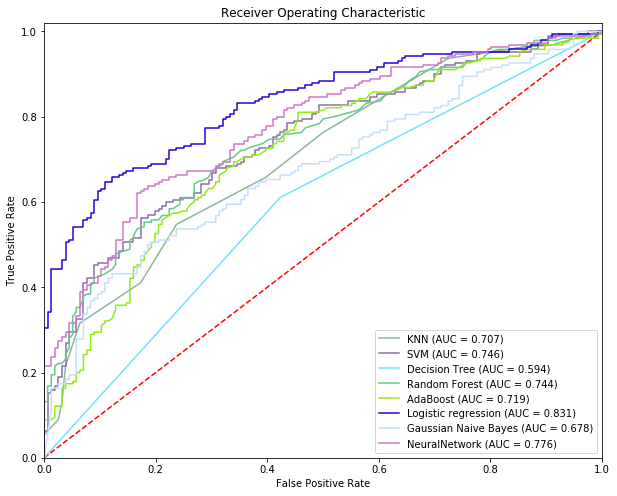

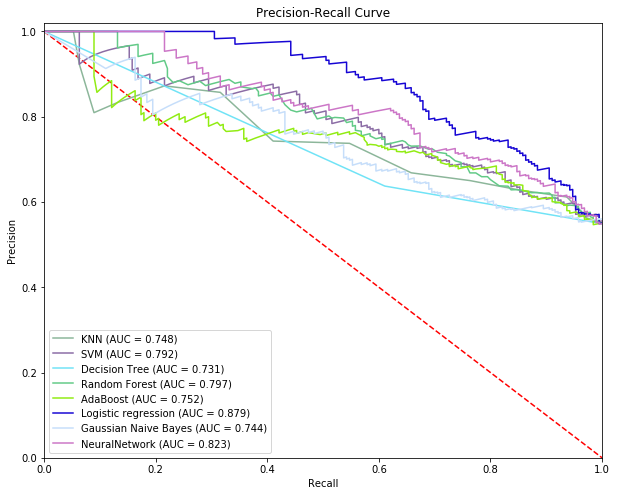

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 8226 to 27958
Data columns (total 24 columns):
LIMIT_BAL                     5000 non-null int64
SEX                           5000 non-null int64
EDUCATION                     5000 non-null int64
MARRIAGE                      5000 non-null int64
AGE                           5000 non-null int64
PAY_0                         5000 non-null int64
PAY_2                         5000 non-null int64
PAY_3                         5000 non-null int64
PAY_4                         5000 non-null int64
PAY_5                         5000 non-null int64
PAY_6                         5000 non-null int64
BILL_AMT1                     5000 non-null int64
BILL_AMT2                     5000 non-null int64
BILL_AMT3                     5000 non-null int64
BILL_AMT4                     5000 non-null int64
BILL_AMT5                     5000 non-null int64
BILL_AMT6                     5000 non-null int64
PAY_AMT1                      5000 non-

KeyboardInterrupt: 

In [12]:
# %%time
files = [file1,file2,file3,file4,file5,file6,file7,file8,file9,file10]
dfs = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

for file,df in zip(files,dfs):
    all_clfs = []
    clf_names = []
    print("Dataset : %s" % file)
    #     df.info()
    X = np.array(df.iloc[:,:-1])
    y = np.array(df.iloc[:,-1])
    assert len(y.shape) == 1, "wrong shape of y"
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    run_all_clfs()